---
# ***GAN Generator for Geological Facies Modeling***
---

This project has the aim to build a Generative Adversarial Network (GAN) from scratch to generate synthetic geological facies models. This will include setting up the environment, preparing the data, building the model, training it and evaluating the results. This project is just and extension and variation of the work implemented by Suihong Song in his [paper](https://link.springer.com/article/10.1007/s10596-021-10059-w) "Geological Facies modeling based on progressive growing of generative adversarial networks (GANs)
Suihong Song (CUPB & Stanford), Tapan Mukerji (Stanford), and Jiagen Hou (CUPB)
CUPB: China University of Petroleum - Beijing". The github repository where I got the dataset and some of the guidlines for implementing my project can be found in this [link](https://github.com/SuihongSong/GeoModeling_Unconditional_ProGAN/tree/master/). It is important to mention that this project provides an implementation of this pro GAN in PyTorch different from the implementation in Keras main by the original authors.


## **Introduction and Setting Up the Environment**

As explained before, the objective of this project is to generate a GAN for generating geological facies models. In general, we know that a GAN consists of two neural networks:


*   Generator (G): Which creates the synthetic data resembling the real one
*   Discriminator (D): Which distinguishes between the real data and the synthetic data geberated by the Generator

Since they are trained simultaneously, we have as a result a minmax game where the Generator tries to minimize the Discriminato's ability to detect fakes, and so on the Discriminator tries to maximize its accuracy. The idea here is to reach out to a point where the Discriminator is not able to recognize which model has been generated by the generator or if it is a real one.

Now, ProGANs (Progressive Growing of GANs) introduce a training methodology where the GAN starts training with low resulution images and progresively increases the resolution by adding layers to both the Generator and the Discriminator. This approach helps in stabilizing training and improving the quality of the generated images. We will be first exploring GANs and then move towards the use of ProGANS because of their complexity



First, let's install the necessary libraries. PyTorch and torchvision are essential for building and training the GAN. Also we are installing other main required libraries like numpy, matplotlib, seaborn, etc.

In [1]:
# Install PyTorch and torchvision
!pip install torch torchvision

# Install other required libraries
!pip install numpy matplotlib seaborn tensorflow tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Now, let's proceed to import all the required libraries for data processing, visualization, and building the GAN.

In [2]:
import os
import time
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn import manifold
from scipy.stats import kde
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Below, you will see the versions of the libraries used

In [3]:
# let's get the version of the libraries that will be used
!python --version
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('Seaborn', sns.__version__)
print("Matplotlib", plt.matplotlib.__version__)
print("TensorFlow", tf.__version__)
print("PyTorch  ", torch.__version__)

Python 3.11.11
NumPy 1.26.4
Pandas 2.2.2
Seaborn 0.13.2
Matplotlib 3.10.0
TensorFlow 2.18.0
PyTorch   2.5.1+cu124


## **Data Preprocessing**

The models that will be used in this project have been generated using Petrel and then have been exported in GSLIB format. The GSLIB files include header lines with metadata (like the number of realizations and property names) and data lines, where each line correspond to a pixel in a 64x64 grid.
These files were converted by the authors to TFR format. The conversion from this format to TFRecord involved the following steps:


**1.   Loading the Facies Model:** Reading the GSLIB file, parsing the facies code and arraging them into Numpy arrays

**2.   Data Augmentation:** Augment the dataset by flipping images to simulate additional geological scenarios.

**3.   Generating Probability Maps:** Apply Gaussian kernel smoothing to create probability maps representing the likelihood of each facies.

**4.   Generating Well Facies Data:** Simulate well data by randomly sampling facies at specific location based on the probability maps

**5. Preparing Labels (Global Features):** Extract global features (e.g., channel orientation, width) and normalize them.

**6.  Saving to TFRecord:** Use a TFRecordExporter class to write the data into TFRecord files for efficient storage and access during training..


In this project, we will convert the TFRecord format into NumPy array and then will create a PyTorch Dataset. For doing this let's create a function to parse the TFRecords and save them as using a Numpy array.
This function reads each TFRecord file, parsing the shape and data features. Then, each  image is reshaped based on its shape. If the image shape doesn't match the desired max_shape, it's resized using OpenCV. Finally, all processed images are stacked into a single NumPy array. The resulting array is saved as a .npy file for later use.

In [4]:
# Function to parse TFRecords and save as NumPy arrays
def convert_tfrecords_to_numpy(tfrecord_filenames, output_file):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_filenames)
    data_list = []
    max_shape = [1, 64, 64]  # Adjust as necessary

    for raw_record in tqdm(raw_dataset, desc="Converting TFRecords"):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        shape = example.features.feature['shape'].int64_list.value
        data = example.features.feature['data'].bytes_list.value[0]
        img = np.frombuffer(data, dtype=np.uint8).reshape(shape)

        # Resize if necessary to max_shape
        if img.shape != tuple(max_shape):
            img_resized = cv2.resize(img[0], (max_shape[2], max_shape[1]))
            img = img_resized[np.newaxis, ...]
        data_list.append(img)

    data_array = np.stack(data_list, axis=0)
    np.save(output_file, data_array)
    print(f"Data saved to {output_file}")


Now, let's proceed to import the datafiles and convert this files into NumPy



In [5]:
# Define the paths to the TFRecord files
tfrecord_filenames = [
    '/content/Training_data/TrainingData(MultiChannels_Version4)-1r02.tfrecords',
    '/content/Training_data/TrainingData(MultiChannels_Version4)-1r03.tfrecords',
    '/content/Training_data/TrainingData(MultiChannels_Version4)-1r04.tfrecords',
    '/content/Training_data/TrainingData(MultiChannels_Version4)-1r05.tfrecords',
    '/content/Training_data/TrainingData(MultiChannels_Version4)-1r06.tfrecords'
]

output_file = 'training_data.npy'

# Converting the tfrecord_filenames to numpy
convert_tfrecords_to_numpy(tfrecord_filenames, output_file)

# Path to the labels file
labels_path = '/content/Training_data/TrainingData(MultiChannels_Version4)-4rxx.labels'

labels = np.load(labels_path)
print('Labels shape:', labels.shape)

Converting TFRecords: 178200it [01:02, 2840.32it/s]


Data saved to training_data.npy
Labels shape: (35640, 4)


We are going now to create the PyTorch Dataset. Here the images are normalized to the range [-1, 1] which is the standard for GAN's. Also, getitem returns a tensor representation of the image

In [6]:
class FaciesDataset(Dataset):
    def __init__(self, data_array):
        self.data = data_array.astype(np.float32)
        # Normalize images from [0,255] to [-1, 1]
        self.data = (self.data / 127.5) - 1.0
        print("Debug => After normalization, min:", self.data.min(), "max:", self.data.max())
        print("Raw data min:", np.min(data_array), "max:", np.max(data_array))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        return torch.from_numpy(image)

Next, we initialize the dataset and the dataloader, here we will have a total of 178,200 samples. Also, the selected batch size will be equal to 16

In [7]:
data_array = np.load('training_data.npy')
subset_size = 2000
indices = np.random.choice(data_array.shape[0], subset_size, replace=False)
data_array = data_array[indices]
print(f"Data shape: {data_array.shape}")  # (num_samples, 1, 64, 64)

dataset = FaciesDataset(data_array)
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

Data shape: (2000, 1, 64, 64)
Debug => After normalization, min: -1.0 max: 1.0
Raw data min: 0 max: 255



## **Exploratory Data Analysis**

### **Image Grid**

Let's start exploring the basic properties of the dataset. First, let's visualize some samples of the data set and explore some of their characteristics

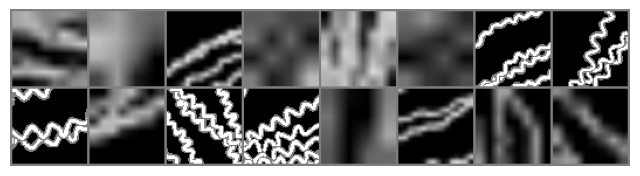

In [8]:
import torchvision


def show_batch_of_images(images, nrow=8):
    """
    images: a torch Tensor of shape (B, C, H, W) in the range [-1,1].
    nrow  : how many images in one row of the grid
    """
    grid_img = torchvision.utils.make_grid(images, nrow=nrow, normalize=False)
    grid_img = grid_img * 0.5 + 0.5  # scale from [-1,1] to [0,1]
    np_img = grid_img.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np_img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

# Usage:
dataiter = iter(dataloader)
images = next(dataiter)
show_batch_of_images(images[:64], nrow=8)

This grid provides a visual overview of the geological facies patterns in the dataset. The variations in texture and intensity indicate the diversity of the geological features captured.


### **PCA Analysis on Flattened Images**

Now, let's proceed to flatten the images to calculate the statistics and compute the mean pixel values and its standard deviation

In [9]:
# Flatten the images to calculate statistics
flat_images = data_array.reshape(data_array.shape[0], -1)

# Calculate mean and standard deviation
mean_pixel_value = flat_images.mean()
std_pixel_value = flat_images.std()

print(f"Mean pixel value: {mean_pixel_value:.4f}")
print(f"Standard deviation of pixel values: {std_pixel_value:.4f}")


Mean pixel value: 77.6793
Standard deviation of pixel values: 77.6256


Once we have done this, let's proceed to see the histogram of the Pixel Values and see how the pixels are mostly concentrated.

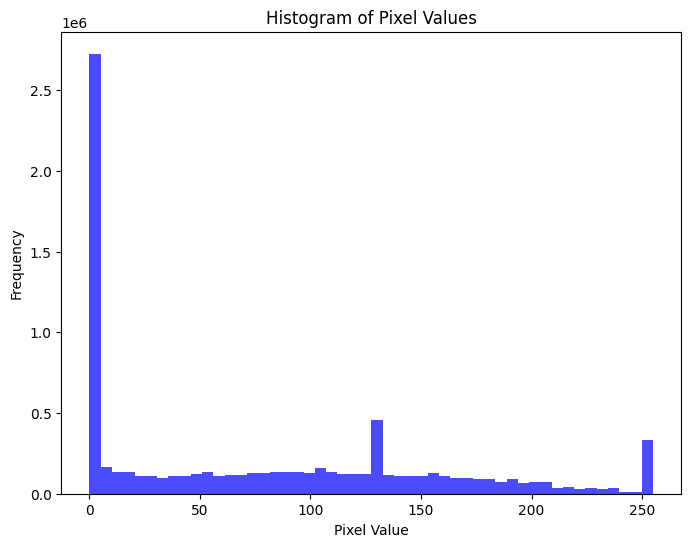

In [10]:
plt.figure(figsize=(8, 6))
plt.hist(flat_images.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

The histogram reveals that most pixel values are concentrated around 0 and 255, suggesting that the dataset primarily contains binary-like data with some intermediate values.

In [11]:
data_flattened = data_array.reshape(data_array.shape[0], -1)  # shape: (N, 64*64)
print("Data flattened shape:", data_flattened.shape)

Data flattened shape: (2000, 4096)


Now we fit PCA to understand the global dimensionality of the data.

Data flattened shape: (2000, 4096)


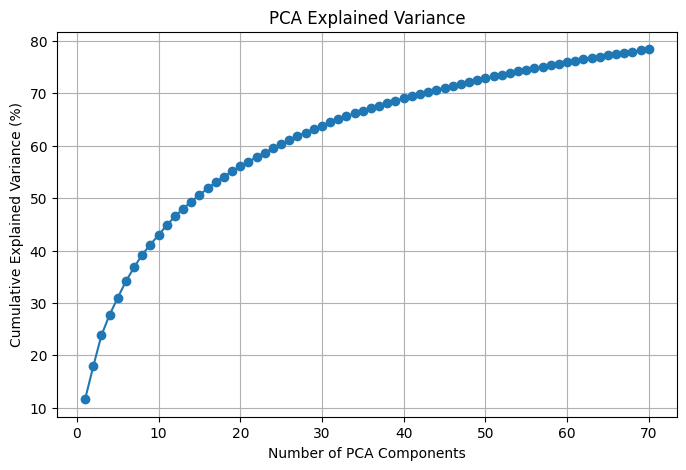

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
data_flattened = data_array.reshape(data_array.shape[0], -1)  # shape: (N, 64*64)
print("Data flattened shape:", data_flattened.shape)

# Fit PCA
n_components = 70  # or any number less than the number of features
pca = PCA(n_components=n_components, random_state=42)
pca.fit(data_flattened)

# Plot explained variance ratio (cumulative)
explained_variance = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()


## **Building and Training the GAN**

Having prepared a more balanced and diverse dataset, we now focus on building and training the GAN model. We will use a progressive growing approach. Instead of starting the GAN at full resolution (64x64), we begin at a lower resolution (e.g., 4x4). We train the model at this low resolution first, which allows it to learn coarse geological structures without being overwhelmed by fine details. After some training, we introduce new layers that double the resolution to 8x8, and we smoothly blend these new layers using a fade-in parameter alpha. This process repeats, going through resolutions like 16x16, 32x32, and finally 64x64. At each stage, we have a fade-in phase (where alpha goes from 0 to 1) and a stable phase (alpha=1.0). This methodology encourages stable training and better-quality results.
Likewise, instead of using all 178,200 images, we randomly choose 20,000 images. This speeds up each epoch because we iterate over fewer images, letting us reach more meaningful training iterations before times out.


In [13]:
class FinalDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx])

final_data = data_array

train_dataset = FaciesDataset(final_data)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

Debug => After normalization, min: -1.0 max: 1.0
Raw data min: 0 max: 255


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Here, it is implemented a Generator and a Discriminator that can grow progressively. The Generator starts with a small 4x4 layer and can add layers to double resolution step by step. The Discriminator works in reverse order. We train them using a WGAN-GP style loss. The Discriminator tries to push real sample scores up and fake sample scores down, while the Generator tries to make fake samples indistinguishable from real ones. The gradient penalty ensures the Discriminator does not become too sharp or saturate, stabilizing training. By carefully adjusting the learning rates, betas for Adam, and balancing the loss terms, we maintain a stable training environment.

First, we will implement some utilities for progressive growing

In [14]:
def upscale2d(x, factor=2):
    return F.interpolate(x, scale_factor=factor, mode='nearest')

class GenBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
        self.activation = nn.LeakyReLU(0.2)
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        return x

class ToRGB(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Conv2d(ch, 1, 1, 1, 0)
    def forward(self, x):
        return self.conv(x)

Now, we can proceed to implement the Generator class

In [15]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim
        # Map latent vector z to a 4x4 feature map with 512 channels
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)
        # Optional learned constant added as a bias
        self.const = nn.Parameter(torch.randn(1, 512, 4, 4))
        # Generator channels for increasing resolution: 4x4:512, 8x8:512, 16x16:256, 32x32:128, 64x64:64
        self.channels = [512, 512, 256, 128, 64]
        self.blocks = nn.ModuleList()
        self.torgb = nn.ModuleList()

        # Base: 4x4 – use ToRGB on 512 channels
        self.torgb.append(ToRGB(self.channels[0]))

        # 4x4 -> 8x8
        self.blocks.append(GenBlock(self.channels[0], self.channels[1]))
        self.torgb.append(ToRGB(self.channels[1]))

        # 8x8 -> 16x16
        self.blocks.append(GenBlock(self.channels[1], self.channels[2]))
        self.torgb.append(ToRGB(self.channels[2]))

        # 16x16 -> 32x32
        self.blocks.append(GenBlock(self.channels[2], self.channels[3]))
        self.torgb.append(ToRGB(self.channels[3]))

        # 32x32 -> 64x64
        self.blocks.append(GenBlock(self.channels[3], self.channels[4]))
        self.torgb.append(ToRGB(self.channels[4]))

        self.alpha = 1.0  # For fade-in blending

    def forward(self, z, resolution_log2):
        # resolution_log2: 2->4x4, 3->8x8, 4->16x16, 5->32x32, 6->64x64
        index = resolution_log2 - 2
        batch = z.size(0)
        # Map latent vector to initial 4x4 feature map and add learned bias
        x = self.fc(z).view(batch, 512, 4, 4)
        x = x + self.const.expand_as(x)
        # Progressive growing: apply blocks until desired resolution
        for i in range(index):
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            x = self.blocks[i](x)
        out_new = self.torgb[index](x)
        # Fade-in blending if needed
        if index > 0 and self.alpha < 1.0:
            y = self.fc(z).view(batch, 512, 4, 4)
            y = y + self.const.expand_as(y)
            for i in range(index - 1):
                y = F.interpolate(y, scale_factor=2, mode='nearest')
                y = self.blocks[i](y)
            out_prev = self.torgb[index - 1](y)
            out_prev_up = F.interpolate(out_prev, scale_factor=2, mode='nearest')
            out = (1.0 - self.alpha) * out_prev_up + self.alpha * out_new
        else:
            out = out_new
        # Final activation maps to [-1, 1]
        out = torch.tanh(out)
        return out

This are the utility classes for the Discriminator

In [16]:
# --- Discriminator Utilities ---
class FromRGB(nn.Module):
    """
    Converts a 1-channel image into feature maps.
    """
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Conv2d(1, ch, 1, 1, 0)
    def forward(self, x):
        return self.conv(x)

class DiscBlock(nn.Module):
    """
    A block that applies two convolutions with LeakyReLU activations.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, in_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
        self.activation = nn.LeakyReLU(0.2)
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        return x

Now we continue the Discriminator

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # We mirror the generator's channel progression but in the reverse order.
        # Generator channels: [512, 512, 256, 128, 64] corresponding to:
        #  4x4, 8x8, 16x16, 32x32, 64x64 respectively.
        # Therefore, we define the discriminator's fromRGB layers so that:
        #   at 4x4: output 512, at 8x8: output 512, at 16x16: 256, 32x32: 128, 64x64: 64.
        self.fromrgb = nn.ModuleList([
            FromRGB(512),  # index 0 for 4x4
            FromRGB(512),  # index 1 for 8x8
            FromRGB(256),  # index 2 for 16x16
            FromRGB(128),  # index 3 for 32x32
            FromRGB(64)    # index 4 for 64x64
        ])
        # Build downsampling blocks so that when processing a resolution level,
        # the block converts the current fromRGB channel count to that of the next lower resolution.
        self.blocks = nn.ModuleList([
            DiscBlock(512, 512),   # For 8x8 -> 4x4 (index 1): input 512 -> output 512
            DiscBlock(256, 512),   # For 16x16 -> 8x8 (index 2): input 256 -> output 512
            DiscBlock(128, 256),   # For 32x32 -> 16x16 (index 3): input 128 -> output 256
            DiscBlock(64, 128)     # For 64x64 -> 32x32 (index 4): input 64 -> output 128
        ])
        # Merge convolution layers for fade-in blending:
        # They adjust the upsampled low-res branch to have the same number of channels as the current resolution.
        self.merge_conv = nn.ModuleList([
            nn.Identity(),   # index 0: not used
            nn.Identity(),   # index 1: for 8x8, previous branch already has 512 channels
            nn.Conv2d(512, 256, 1, 1),  # index 2: convert from 512 (fromRGB[1]) to 256 (fromRGB[2])
            nn.Conv2d(256, 128, 1, 1),  # index 3: convert from 256 (fromRGB[2]) to 128 (fromRGB[3])
            nn.Conv2d(128, 64, 1, 1)    # index 4: convert from 128 (fromRGB[3]) to 64 (fromRGB[4])
        ])
        # Final layers (after downsampling to 4x4, we expect 512 channels)
        self.final_conv = nn.ModuleList([
            nn.Conv2d(512, 512, 3, 1, 1),  # index 0: 4x4
            nn.Conv2d(512, 512, 3, 1, 1),  # index 1: 8x8
            nn.Conv2d(512, 512, 3, 1, 1),  # index 2: 16x16
            nn.Conv2d(512, 512, 3, 1, 1),  # index 3: 32x32
            nn.Conv2d(512, 512, 3, 1, 1)   # index 4: 64x64
        ])
        self.final_fc = nn.ModuleList([
            nn.Linear(512 * 4 * 4, 1),  # index 0
            nn.Linear(512 * 4 * 4, 1),  # index 1
            nn.Linear(512 * 4 * 4, 1),  # index 2
            nn.Linear(512 * 4 * 4, 1),  # index 3
            nn.Linear(512 * 4 * 4, 1)   # index 4
        ])
        self.alpha = 1.0  # For fade-in blending

    def forward(self, x, resolution_log2):
        # Compute index: index = resolution_log2 - 2.
        # For example, for 8x8, resolution_log2=3 and index=1.
        index = resolution_log2 - 2
        if index > 0 and self.alpha < 1.0:
            # High-resolution path at current resolution.
            high = self.fromrgb[index](x)
            # Low-resolution branch: downsample and use previous fromRGB.
            x_down = F.avg_pool2d(x, 2)
            low = self.fromrgb[index - 1](x_down)
            low_up = F.interpolate(low, scale_factor=2, mode='nearest')
            low_up = self.merge_conv[index](low_up)
            out = (1.0 - self.alpha) * low_up + self.alpha * high
        else:
            out = self.fromrgb[index](x)
        # Process through downsampling blocks.
        for i in range(index, 0, -1):
            out = self.blocks[i - 1](out)
            out = F.avg_pool2d(out, 2)
        out = F.leaky_relu(self.final_conv[index](out), 0.2)
        out = out.view(out.size(0), -1)
        out = self.final_fc[index](out)
        return out

With the models and utility functions defined, we proceed with the training loop. We specify a series of resolutions and train through them. For each resolution, we do a fade-in phase (alpha from 0 to 1) and a stable phase (alpha=1). Each batch involves:

1. Sampling latent vectors z.
2. Generating fake images.
3. Computing Discriminator loss (WGAN-GP): real_out should be high, fake_out low, plus the gradient penalty.
4. Updating the Discriminator.
5. Updating the Generator to produce more realistic images.

This iterative process is repeated for each resolution until we reach the final target resolution.

In [18]:
def sample_latent(batch_size, latent_dim=128, device='cuda'):
    """
    Samples latent vectors from a standard normal distribution.

    Args:
        batch_size (int): Number of samples to generate.
        latent_dim (int): Dimensionality of the latent space.
        device (torch.device): Device to place the tensor.

    Returns:
        torch.Tensor: Sampled latent vectors.
    """
    return torch.randn(batch_size, latent_dim, device=device)

def gradient_penalty(D, real, fake, resolution_log2, device='cuda'):
    """
    Computes the gradient penalty for WGAN-GP.

    Args:
        D (nn.Module): Discriminator model.
        real (torch.Tensor): Real images.
        fake (torch.Tensor): Fake images generated by the Generator.
        resolution_log2 (int): Log2 of the current resolution.
        device (torch.device): Device to perform computations.

    Returns:
        torch.Tensor: Gradient penalty.
    """
    alpha = torch.rand(real.size(0), 1, 1, 1, device=device)
    interp = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interp = D(interp, resolution_log2)
    grad = torch.autograd.grad(
        outputs=d_interp, inputs=interp,
        grad_outputs=torch.ones_like(d_interp),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad = grad.view(grad.size(0), -1)
    norm = grad.norm(2, dim=1)
    gp = ((norm - 1) ** 2).mean()
    return gp

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Generator and Discriminator
G = Generator(latent_dim=128).to(device)
D = Discriminator().to(device)

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.kaiming_normal_(m.weight, a=0.2)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

G.apply(init_weights)
D.apply(init_weights)

# Define optimizers (updated per-resolution learning rates)
# Revised learning rate schedule:
resolution_lr_map = {
    4:  (5e-6, 5e-6),
    8:  (5e-6, 5e-6),
    16: (1e-6, 1e-6),
    32: (5e-6, 5e-6),
    64: (1e-6, 1e-6)
}

optimizer_G = optim.Adam(G.parameters(), lr=5e-6, betas=(0.0, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=5e-6, betas=(0.0, 0.9))

# Mixed precision scalers
scaler_G = GradScaler()
scaler_D = GradScaler()

Using device: cuda


<ipython-input-18-584aae7d89fb>:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_G = GradScaler()
<ipython-input-18-584aae7d89fb>:78: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_D = GradScaler()


We proceed to implement the training parameters

In [22]:
# Progressive resolutions to train on
resolutions = [4, 8, 16, 32, 64]
# Training parameters (in kilo-images, i.e. 1 kimg = 1000 images)
fade_in_kimg = 2000
stable_kimg = 2000
latent_dim = 128

# Initialize Mixed Precision Scalers
scaler_G = GradScaler()
scaler_D = GradScaler()

<ipython-input-22-9c8b501cba7e>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_G = GradScaler()
<ipython-input-22-9c8b501cba7e>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_D = GradScaler()


Now, we proceed with the Training. First we are gonna set some checkpoint functions in case we disconnect and want to continue with the training later. We are also going to implement some utility functions that will allow us to keep a record of the losses and the gradients obtained in each phase

In [24]:
import re
import json
from google.colab import drive
drive.mount('/content/drive')

# ========= Utility to Compute Gradient Norm =========
def compute_grad_norm(model):
    """
    Computes the total L2 norm of the gradients for the model, while printing
    detailed statistics for each parameter's gradient. If NaNs are found in any
    parameter's gradient, it prints a warning along with min, max, and mean values.

    Returns:
        total_norm (float): The total L2 norm of gradients across parameters.
    """
    grad_norms = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad = param.grad.detach()
            # Check if this gradient tensor has any NaN values
            if torch.isnan(grad).any():
                continue
            norm = grad.norm(2).item()
            grad_norms.append(norm)
    if len(grad_norms) == 0:
        return float('nan')
    return sum(grad_norms) / len(grad_norms)

# ========= Loss History Functions =========
# Save the loss history JSON file in the checkpoints folder.
checkpoint_dir = "/content/drive/MyDrive/ProGAN_Checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
loss_history_file = os.path.join(checkpoint_dir, "loss_history.json")

def load_loss_history(loss_history_file):
    if os.path.exists(loss_history_file):
        with open(loss_history_file, "r") as f:
            return json.load(f)
    else:
        return {}

def save_loss_history(loss_history, loss_history_file):
    with open(loss_history_file, "w") as f:
        json.dump(loss_history, f, indent=4)

# Load any existing loss history.
loss_history = load_loss_history(loss_history_file)

# ========= Checkpoint Functions =========
def get_latest_checkpoint(checkpoint_dir):
    pattern = re.compile(r"^(fadein|stable)_res(\d+)\.pth$")
    latest = None
    for filename in os.listdir(checkpoint_dir):
        match = pattern.match(filename)
        if match:
            phase, res_str = match.groups()
            res = int(res_str)
            if latest is None:
                latest = {"path": os.path.join(checkpoint_dir, filename),
                          "resolution": res, "phase": phase}
            else:
                if res > latest["resolution"]:
                    latest = {"path": os.path.join(checkpoint_dir, filename),
                              "resolution": res, "phase": phase}
                elif res == latest["resolution"]:
                    if phase == "stable" and latest["phase"] != "stable":
                        latest = {"path": os.path.join(checkpoint_dir, filename),
                                  "resolution": res, "phase": phase}
    return latest

# ========= Checkpoint Resume Settings =========
resume_training = True  # Set to True if you want to resume training
latest_ckpt = None
if resume_training:
    latest_ckpt = get_latest_checkpoint(checkpoint_dir)

if latest_ckpt:
    print("Found checkpoint:", latest_ckpt["path"])
    ckpt = torch.load(latest_ckpt["path"], map_location=device)
    G.load_state_dict(ckpt['G_state_dict'])
    D.load_state_dict(ckpt['D_state_dict'])
    optimizer_G.load_state_dict(ckpt['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(ckpt['optimizer_D_state_dict'])
    G.alpha = ckpt.get('alpha', 1.0)
    D.alpha = ckpt.get('alpha', 1.0)
    # Note: We'll use the existence of stored metrics for each resolution
    # rather than a single global "resume_res" value.
    resume_res = ckpt.get('resolution', None)
    resume_phase = ckpt.get('phase', None)
    print(f"Resuming training from resolution {resume_res} and phase '{resume_phase}'.")
else:
    print("No checkpoint found. Starting training from scratch.")
    resume_res = 0
    resume_phase = None



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found checkpoint: /content/drive/MyDrive/ProGAN_Checkpoints/stable_res4.pth


<ipython-input-24-043e4ebe85ca>:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(latest_ckpt["path"], map_location=device)


Resuming training from resolution 4 and phase 'stable'.


Now we proceed to run the training loop

Resolution 4x4 already fully trained.


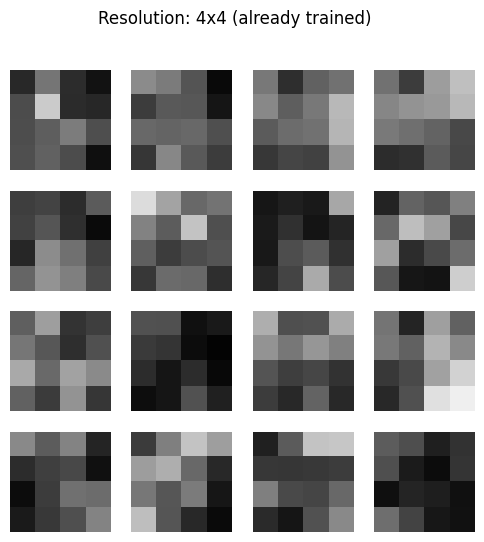


===> Training resolution 8x8: setting G_lr=5e-06, D_lr=5e-06
Resolution: 8x8 - Starting Fade-in Phase


Fade-In Phase:   0%|          | 0/125000 [00:00<?, ?it/s]<ipython-input-26-e57c5f291478>:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-26-e57c5f291478>:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Fade-In Phase: 100%|██████████| 125000/125000 [1:12:14<00:00, 28.84it/s]


[Fade-in finished @ 8x8] - Final alpha: 1.00
  * Avg D loss: -2.1759, Avg G loss: 17.2342
  * Avg D real output: -13.6629, Avg D fake output: -17.2342
Saved fade-in checkpoint: /content/drive/MyDrive/ProGAN_Checkpoints/fadein_res8.pth
Resolution: 8x8 - Starting Stable Phase


Stable Phase:   0%|          | 0/125000 [00:00<?, ?it/s]<ipython-input-26-e57c5f291478>:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-26-e57c5f291478>:181: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Stable Phase: 100%|██████████| 125000/125000 [1:05:17<00:00, 31.91it/s]


[Stable phase finished @ 8x8]
  * Final alpha: 1.00
  * Avg D loss: -2.0242, Avg G loss: 12.1836
  * Avg D real output: -9.2287, Avg D fake output: -12.1836
Saved stable checkpoint: /content/drive/MyDrive/ProGAN_Checkpoints/stable_res8.pth


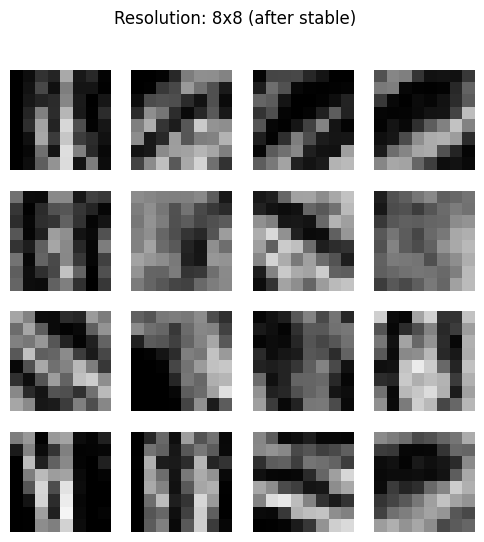


===> Training resolution 16x16: setting G_lr=1e-06, D_lr=1e-06
Resolution: 16x16 - Starting Fade-in Phase


Fade-In Phase: 100%|██████████| 125000/125000 [2:12:47<00:00, 15.69it/s]


[Fade-in finished @ 16x16] - Final alpha: 1.00
  * Avg D loss: -2.3497, Avg G loss: 5.8959
  * Avg D real output: -2.6829, Avg D fake output: -5.8959
Saved fade-in checkpoint: /content/drive/MyDrive/ProGAN_Checkpoints/fadein_res16.pth
Resolution: 16x16 - Starting Stable Phase


Stable Phase: 100%|██████████| 125000/125000 [1:54:07<00:00, 18.26it/s]


[Stable phase finished @ 16x16]
  * Final alpha: 1.00
  * Avg D loss: -3.4357, Avg G loss: 4.3193
  * Avg D real output: 0.6562, Avg D fake output: -4.3193
Saved stable checkpoint: /content/drive/MyDrive/ProGAN_Checkpoints/stable_res16.pth


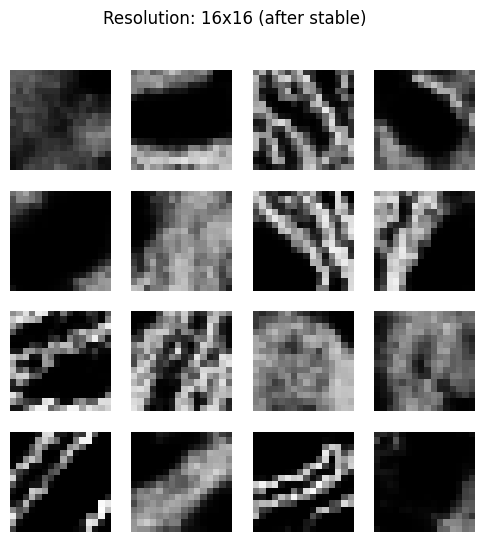


===> Training resolution 32x32: setting G_lr=5e-06, D_lr=5e-06
Resolution: 32x32 - Starting Fade-in Phase


Fade-In Phase: 100%|██████████| 125000/125000 [3:37:00<00:00,  9.60it/s]


[Fade-in finished @ 32x32] - Final alpha: 1.00
  * Avg D loss: -5.3930, Avg G loss: 27.6116
  * Avg D real output: -18.6057, Avg D fake output: -27.6116
Saved fade-in checkpoint: /content/drive/MyDrive/ProGAN_Checkpoints/fadein_res32.pth
Resolution: 32x32 - Starting Stable Phase


Stable Phase: 100%|██████████| 125000/125000 [2:57:04<00:00, 11.77it/s]


[Stable phase finished @ 32x32]
  * Final alpha: 1.00
  * Avg D loss: -6.8121, Avg G loss: 32.2252
  * Avg D real output: -20.7850, Avg D fake output: -32.2252
Saved stable checkpoint: /content/drive/MyDrive/ProGAN_Checkpoints/stable_res32.pth


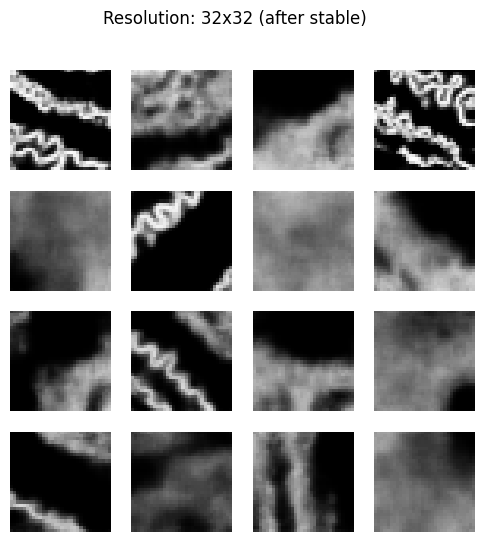


===> Training resolution 64x64: setting G_lr=1e-06, D_lr=1e-06
Resolution: 64x64 - Starting Fade-in Phase


Fade-In Phase: 100%|██████████| 125000/125000 [5:44:46<00:00,  6.04it/s]


[Fade-in finished @ 64x64] - Final alpha: 1.00
  * Avg D loss: -2.8241, Avg G loss: -11.9054
  * Avg D real output: 16.0762, Avg D fake output: 11.9054
Saved fade-in checkpoint: /content/drive/MyDrive/ProGAN_Checkpoints/fadein_res64.pth
Resolution: 64x64 - Starting Stable Phase


Stable Phase: 100%|██████████| 125000/125000 [4:39:09<00:00,  7.46it/s]


[Stable phase finished @ 64x64]
  * Final alpha: 1.00
  * Avg D loss: -11.6157, Avg G loss: -4.2785
  * Avg D real output: 25.7003, Avg D fake output: 4.2785
Saved stable checkpoint: /content/drive/MyDrive/ProGAN_Checkpoints/stable_res64.pth


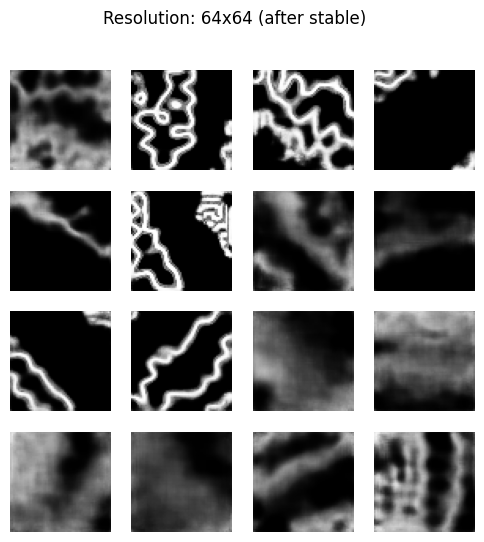

Training complete!


In [26]:
# ========= Reinitialize Data Iterator =========
dataiter = iter(dataloader)

# ========= Progressive Training Loop with Loss Metrics and Preview =========
for res in resolutions:
    resolution_log2 = int(np.log2(res))
    key_stable = f"res_{res}_stable"
    key_fadein = f"res_{res}_fadein"

    # If stored stable metrics exist, consider that resolution fully trained.
    if key_stable in loss_history:
        print(f"Resolution {res}x{res} already fully trained.")
        # (You may choose to print stored metrics here if desired.)
        with torch.no_grad():
            z_preview = torch.randn(16, latent_dim, device=device)
            fakes_preview = G(z_preview, resolution_log2=resolution_log2).cpu().numpy()
            fakes_disp = (fakes_preview * 0.5) + 0.5
        fig, axs = plt.subplots(4, 4, figsize=(6,6))
        for i in range(16):
            ax = axs[i // 4, i % 4]
            ax.imshow(fakes_disp[i, 0], cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        fig.suptitle(f"Resolution: {res}x{res} (already trained)")
        plt.show()
        continue
    # If stored fadein metrics exist but stable metrics do not, then training is partially done.
    elif key_fadein in loss_history:
        print(f"Resolution {res}x{res} already completed fade-in phase. Stored fade-in metrics exist; proceeding with stable phase.")
        # (Optionally, you could print stored fadein metrics here.)

    # Otherwise, if no stored metrics exist, train from scratch for this resolution.
    print(f"\n===> Training resolution {res}x{res}: setting G_lr={resolution_lr_map.get(res)[0]}, D_lr={resolution_lr_map.get(res)[1]}")
    for param_group in optimizer_G.param_groups:
        param_group["lr"] = resolution_lr_map.get(res)[0]
    for param_group in optimizer_D.param_groups:
        param_group["lr"] = resolution_lr_map.get(res)[1]

    # ---------- Fade-in Phase ----------
    # If stored fadein metrics exist, skip fade-in.
    if key_fadein in loss_history:
        print(f"Skipping fade-in phase for {res}x{res} (already completed).")
    else:
        print(f"Resolution: {res}x{res} - Starting Fade-in Phase")
        G.alpha = 0.0
        D.alpha = 0.0
        fade_in_iterations = int((fade_in_kimg * 1000) // batch_size)
        pbar = tqdm(total=fade_in_iterations, desc="Fade-In Phase")
        total_d_loss_fade = 0.0
        total_g_loss_fade = 0.0
        total_d_real_out_fade = 0.0
        total_d_fake_out_fade = 0.0

        for iteration in range(fade_in_iterations):
            alpha_value = (iteration + 1) / fade_in_iterations
            G.alpha = alpha_value
            D.alpha = alpha_value

            try:
                real_images = next(dataiter)
            except StopIteration:
                dataiter = iter(dataloader)
                real_images = next(dataiter)
            real_images = real_images.to(device)
            if 64 // res > 1:
                real_images = F.avg_pool2d(real_images, 64 // res)

            # Train Discriminator
            optimizer_D.zero_grad()
            with torch.cuda.amp.autocast():
                z = sample_latent(real_images.size(0), latent_dim, device=device)
                fake_images = G(z, resolution_log2)
                real_out = D(real_images, resolution_log2)
                fake_out = D(fake_images.detach(), resolution_log2)
                d_loss_real = -real_out.mean()
                d_loss_fake = fake_out.mean()
                gp = gradient_penalty(D, real_images, fake_images, resolution_log2, device=device)
                d_loss = d_loss_real + d_loss_fake + 0.5 * gp
            scaler_D.scale(d_loss).backward()
            try:
                scaler_D.unscale_(optimizer_D)
            except RuntimeError:
                pass
            torch.nn.utils.clip_grad_norm_(D.parameters(), 1.0)
            scaler_D.step(optimizer_D)
            scaler_D.update()

            # Train Generator
            optimizer_G.zero_grad()
            with torch.cuda.amp.autocast():
                z = sample_latent(real_images.size(0), latent_dim, device=device)
                fake_images = G(z, resolution_log2)
                fake_out = D(fake_images, resolution_log2)
                g_loss = -fake_out.mean()
            scaler_G.scale(g_loss).backward()
            try:
                scaler_G.unscale_(optimizer_G)
            except RuntimeError:
                pass
            torch.nn.utils.clip_grad_norm_(G.parameters(), 1.0)
            scaler_G.step(optimizer_G)
            scaler_G.update()

            total_d_loss_fade += d_loss.item()
            total_g_loss_fade += g_loss.item()
            total_d_real_out_fade += real_out.mean().item()
            total_d_fake_out_fade += fake_out.mean().item()
            pbar.update(1)
        pbar.close()
        avg_d_loss_fade = total_d_loss_fade / fade_in_iterations
        avg_g_loss_fade = total_g_loss_fade / fade_in_iterations
        avg_d_real_out_fade = total_d_real_out_fade / fade_in_iterations
        avg_d_fake_out_fade = total_d_fake_out_fade / fade_in_iterations

        print(f"[Fade-in finished @ {res}x{res}] - Final alpha: {G.alpha:.2f}")
        print(f"  * Avg D loss: {avg_d_loss_fade:.4f}, Avg G loss: {avg_g_loss_fade:.4f}")
        print(f"  * Avg D real output: {avg_d_real_out_fade:.4f}, Avg D fake output: {avg_d_fake_out_fade:.4f}")

        ckpt_path = os.path.join(checkpoint_dir, f"fadein_res{res}.pth")
        torch.save({
            'G_state_dict': G.state_dict(),
            'D_state_dict': D.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'alpha': G.alpha,
            'resolution': res,
            'phase': 'fadein'
        }, ckpt_path)
        print(f"Saved fade-in checkpoint: {ckpt_path}")
        loss_history[key_fadein] = {
            "avg_D_loss": avg_d_loss_fade,
            "avg_G_loss": avg_g_loss_fade,
            "avg_D_real_output": avg_d_real_out_fade,
            "avg_D_fake_output": avg_d_fake_out_fade,
            "alpha": G.alpha
        }
        save_loss_history(loss_history, loss_history_file)

    # ---------- Stable Phase ----------
    print(f"Resolution: {res}x{res} - Starting Stable Phase")
    G.alpha = 1.0
    D.alpha = 1.0
    stable_iterations = int((stable_kimg * 1000) // batch_size)
    pbar = tqdm(total=stable_iterations, desc="Stable Phase")
    total_d_loss_stable = 0.0
    total_g_loss_stable = 0.0
    total_d_real_out_stable = 0.0
    total_d_fake_out_stable = 0.0

    for iteration in range(stable_iterations):
        try:
            real_images = next(dataiter)
        except StopIteration:
            dataiter = iter(dataloader)
            real_images = next(dataiter)
        real_images = real_images.to(device)
        if 64 // res > 1:
            real_images = F.avg_pool2d(real_images, 64 // res)

        # Train Discriminator
        optimizer_D.zero_grad()
        with torch.cuda.amp.autocast():
            z = sample_latent(real_images.size(0), latent_dim, device=device)
            fake_images = G(z, resolution_log2)
            real_out = D(real_images, resolution_log2)
            fake_out = D(fake_images.detach(), resolution_log2)
            d_loss_real = -real_out.mean()
            d_loss_fake = fake_out.mean()
            gp = gradient_penalty(D, real_images, fake_images, resolution_log2, device=device)
            d_loss = d_loss_real + d_loss_fake + 0.5 * gp
        scaler_D.scale(d_loss).backward()
        try:
            scaler_D.unscale_(optimizer_D)
        except RuntimeError:
            pass
        torch.nn.utils.clip_grad_norm_(D.parameters(), 1.0)
        scaler_D.step(optimizer_D)
        scaler_D.update()

        # Train Generator
        optimizer_G.zero_grad()
        with torch.cuda.amp.autocast():
            z = sample_latent(real_images.size(0), latent_dim, device=device)
            fake_images = G(z, resolution_log2)
            fake_out = D(fake_images, resolution_log2)
            g_loss = -fake_out.mean()
        scaler_G.scale(g_loss).backward()
        try:
            scaler_G.unscale_(optimizer_G)
        except RuntimeError:
            pass
        torch.nn.utils.clip_grad_norm_(G.parameters(), 1.0)
        scaler_G.step(optimizer_G)
        scaler_G.update()

        total_d_loss_stable += d_loss.item()
        total_g_loss_stable += g_loss.item()
        total_d_real_out_stable += real_out.mean().item()
        total_d_fake_out_stable += fake_out.mean().item()
        pbar.update(1)
    pbar.close()
    avg_d_loss_stable = total_d_loss_stable / stable_iterations
    avg_g_loss_stable = total_g_loss_stable / stable_iterations
    avg_d_real_out_stable = total_d_real_out_stable / stable_iterations
    avg_d_fake_out_stable = total_d_fake_out_stable / stable_iterations

    print(f"[Stable phase finished @ {res}x{res}]")
    print(f"  * Final alpha: {G.alpha:.2f}")
    print(f"  * Avg D loss: {avg_d_loss_stable:.4f}, Avg G loss: {avg_g_loss_stable:.4f}")
    print(f"  * Avg D real output: {avg_d_real_out_stable:.4f}, Avg D fake output: {avg_d_fake_out_stable:.4f}")

    ckpt_path = os.path.join(checkpoint_dir, f"stable_res{res}.pth")
    torch.save({
        'G_state_dict': G.state_dict(),
        'D_state_dict': D.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'alpha': G.alpha,
        'resolution': res,
        'phase': 'stable'
    }, ckpt_path)
    print(f"Saved stable checkpoint: {ckpt_path}")
    loss_history[key_stable] = {
        "avg_D_loss": avg_d_loss_stable,
        "avg_G_loss": avg_g_loss_stable,
        "avg_D_real_output": avg_d_real_out_stable,
        "avg_D_fake_output": avg_d_fake_out_stable,
        "alpha": G.alpha
    }
    save_loss_history(loss_history, loss_history_file)

    # ---------- Preview Generation ----------
    with torch.no_grad():
        z_preview = torch.randn(16, latent_dim, device=device)
        fakes_preview = G(z_preview, resolution_log2=resolution_log2).cpu().numpy()
        fakes_disp = (fakes_preview * 0.5) + 0.5
    fig, axs = plt.subplots(4, 4, figsize=(6,6))
    for i in range(16):
        ax = axs[i // 4, i % 4]
        ax.imshow(fakes_disp[i, 0], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    fig.suptitle(f"Resolution: {res}x{res} (after stable)")
    plt.show()

print("Training complete!")

After training, we can use the saved generator model to produce synthetic geological facies models and visually inspect them. This serves as a quick quality check of the model's performance. Additional quantitative evaluations (like spatial continuity metrics or multi-scale sliced Wasserstein distance) can be implemented as desired.

In [27]:
# Save models
torch.save(G.state_dict(), "generator_model.pth")
torch.save(D.state_dict(), "discriminator_model.pth")


## **Evaluating the Generated Model**

For this section, we proceed to evaluate the quality and diversity of the geological facies models generated by the GAN. The evaluation is conducted through both qualitative and quantitative assessments to ensure that the generated facies resemble realistic geological patterns and capture the variability of the training data.


In [28]:
# We load the trained generator model weights (in case you restarted the kernel after training)
G_loaded = Generator(latent_dim=128).to(device)
G_loaded.load_state_dict(torch.load("generator_model.pth", map_location=device))
G_loaded.eval()

<ipython-input-28-937dcbf64ad1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_loaded.load_state_dict(torch.load("generator_model.pth", map_location=device))


Generator(
  (fc): Linear(in_features=128, out_features=8192, bias=True)
  (blocks): ModuleList(
    (0): GenBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (1): GenBlock(
      (conv1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (2): GenBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (3): GenBlock(
      (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

  We begin by generating a batch of synthetic facies models and directly comparing them to real samples from the dataset. This allows us to assess whether the GAN successfully replicates realistic facies boundaries, spatial patterns, and overall geological structures. By visualizing multiple samples, we can identify any obvious artifacts or anomalies that may indicate issues like mode collapse or insufficient training.

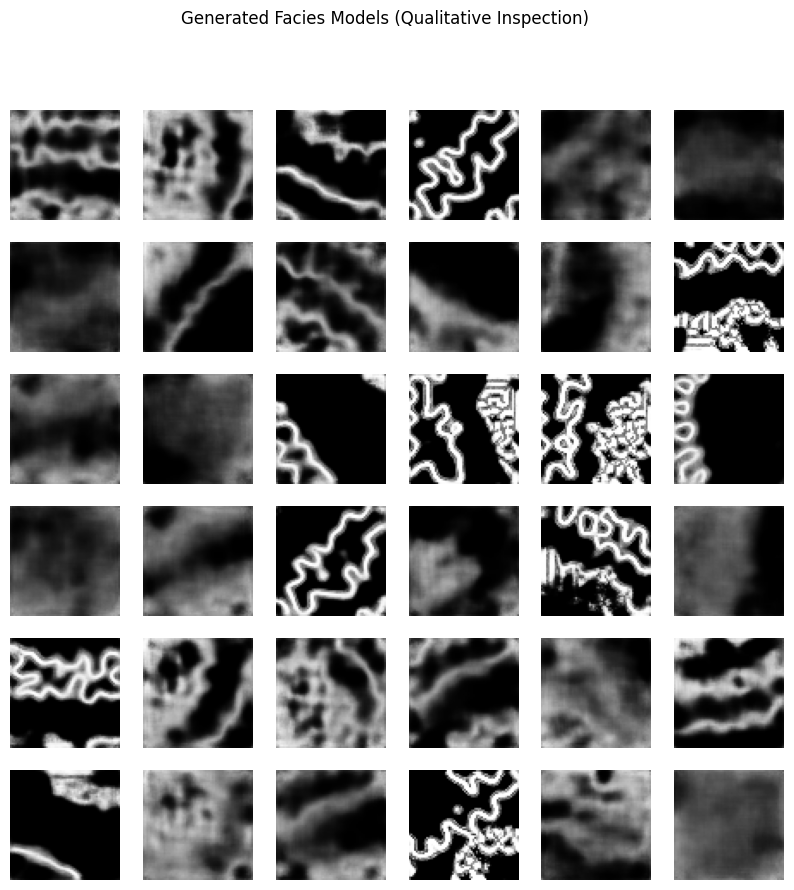

In [29]:
# Generate a batch of synthetic facies models for inspection
with torch.no_grad():
    z = torch.randn(36, 128, device=device)
    # Assume final resolution is 64x64 -> resolution_log2 = 6
    fake_samples = G_loaded(z, resolution_log2=6).cpu().numpy()

fake_samples_disp = (fake_samples * 0.5) + 0.5  # map to [0,1]
fig, axs = plt.subplots(6, 6, figsize=(10,10))
for i, ax in enumerate(axs.flat):
    ax.imshow(fake_samples_disp[i, 0], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
plt.suptitle("Generated Facies Models (Qualitative Inspection)")
plt.show()

  To quantitatively measure the similarity between the generated and real facies distributions, we employ the **Multi-Scale Sliced Wasserstein Distance (MS-SWD)**. MS-SWD evaluates the distance between the statistical distributions of real and synthetic images across multiple spatial scales, providing a comprehensive metric of distributional alignment. Lower MS-SWD values signify a closer match between the generated data and the real data distribution, indicating effective training.

In [30]:
def pixel_norm_desc(desc):
    desc = desc - np.mean(desc, axis=(0,2,3), keepdims=True)
    desc = desc / (np.std(desc, axis=(0,2,3), keepdims=True) + 1e-8)
    desc = desc.reshape(desc.shape[0], -1)
    return desc

def get_descriptors(minibatch, nhood_size=5, nhoods_per_image=32):
    # minibatch: [N,3,H,W] assumed 3-channel
    # If single-channel, we repeat it 3 times to form RGB-like
    S = minibatch.shape
    assert S[1] == 3
    N = nhoods_per_image * S[0]
    H = nhood_size // 2
    nhood, chan, x, y = np.ogrid[0:N, 0:3, -H:H+1, -H:H+1]
    img = nhood // nhoods_per_image
    x = x + np.random.randint(H, S[3]-H, size=(N,1,1,1))
    y = y + np.random.randint(H, S[2]-H, size=(N,1,1,1))
    idx = ((img * S[1] + chan)*S[2] + y)*S[3] + x
    desc = minibatch.flatten()[idx]
    return desc

def sliced_wasserstein(A, B, dir_repeats=4, dirs_per_repeat=64):
    # A, B: descriptors [N, D]
    results = []
    for _ in range(dir_repeats):
        dirs = np.random.randn(A.shape[1], dirs_per_repeat)
        dirs /= np.sqrt(np.sum(dirs**2, axis=0, keepdims=True))
        projA = np.matmul(A, dirs)
        projB = np.matmul(B, dirs)
        projA = np.sort(projA, axis=0)
        projB = np.sort(projB, axis=0)
        dists = np.abs(projA - projB)
        results.append(np.mean(dists))
    return np.mean(results)

# Prepare real and fake samples for MS-SWD evaluation
# Let's load a subset of real images from the original training dataset (data_array)
# If you do not have it, ensure that "data_array" from earlier steps is still in memory:
data_array = final_data
if 'data_array' not in globals():
    data_array = np.load('training_data.npy')  # original training data
# We will use 256 images for evaluation
num_eval = 256
indices = np.random.choice(data_array.shape[0], num_eval, replace=False)
real_subset = data_array[indices]  # shape (N,1,64,64)
real_subset = (real_subset / 127.5) -1.0
real_subset_3c = np.repeat(real_subset, 3, axis=1)  # Convert 1-channel to 3-channel

# Generate fake images for MS-SWD evaluation
with torch.no_grad():
    z = torch.randn(num_eval, 128, device=device)
    fakes = G_loaded(z, resolution_log2=6).cpu().numpy()
fakes_3c = np.repeat(fakes, 3, axis=1)
fakes_3c_uint8 = np.clip((fakes_3c*127.5+127.5),0,255).astype(np.uint8)
reals_3c_uint8 = np.clip((real_subset_3c*127.5+127.5),0,255).astype(np.uint8)

# Extract descriptors
desc_real_list = []
desc_fake_list = []
num_levels = 1  # We only consider single-level SWD for simplicity, or you can do multi-level by downscaling

# Extract descriptors from real and fake
desc_real = get_descriptors(reals_3c_uint8)
desc_real = desc_real.reshape(-1,3,5,5)  # nhood_size=5
desc_real = pixel_norm_desc(desc_real)

desc_fake = get_descriptors(fakes_3c_uint8)
desc_fake = desc_fake.reshape(-1,3,5,5)
desc_fake = pixel_norm_desc(desc_fake)

ms_swd_value = sliced_wasserstein(desc_real, desc_fake)
print("MS-SWD value (x1e3):", ms_swd_value*1e3)

MS-SWD value (x1e3): 106.93396029575602


  Assessing the geological realism of the generated models requires analyzing their spatial continuity and structural integrity. We utilize **variograms** to compare the spatial patterns of facies in the generated models against those in the real dataset. Variograms measure the degree of spatial correlation as a function of distance, allowing us to verify whether the GAN has accurately captured the spatial dependencies and geological anisotropies present in the real data.

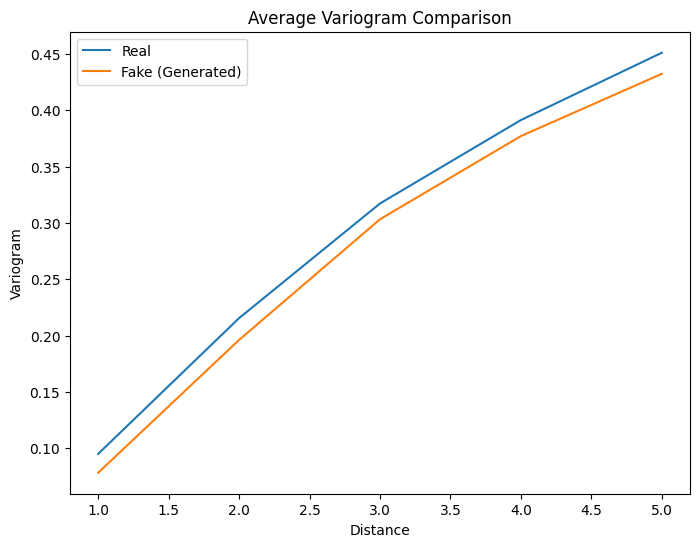

In [31]:
# Let's compute variograms for both real and generated samples and compare.

max_distance = 5

# Function to calculate variogram
def calculate_variogram(image, max_distance):
    if image.ndim != 2:  # Ensure the input is 2D
        raise ValueError("Input image must be 2D.")

    h, w = image.shape
    variogram = []
    for d in range(1, max_distance + 1):  # Loop through distances
        diffs = []
        for i in range(h - d):
            for j in range(w - d):
                diff = (image[i, j] - image[i + d, j + d]) ** 2
                diffs.append(diff)
        variogram.append(np.mean(diffs))
    return variogram

# Take a small sample of real images and compute variogram of their average
real_for_variogram = real_subset[:10,0]  # shape (10,64,64)
fake_for_variogram = fakes[:10,0]        # shape (10,64,64)

def average_variogram(imgs, max_distance):
    all_variograms = []
    for img in imgs:
        vario = calculate_variogram(img, max_distance)
        all_variograms.append(vario)
    return np.mean(all_variograms, axis=0)

real_vario = average_variogram(real_for_variogram, max_distance)
fake_vario = average_variogram(fake_for_variogram, max_distance)

plt.figure(figsize=(8,6))
plt.plot(range(1,max_distance+1), real_vario, label='Real')
plt.plot(range(1,max_distance+1), fake_vario, label='Fake (Generated)')
plt.xlabel('Distance')
plt.ylabel('Variogram')
plt.title('Average Variogram Comparison')
plt.legend()
plt.show()

  Beyond similarity, it's crucial to ensure that the GAN-generated models exhibit sufficient diversity, reflecting the variability inherent in geological formations. We analyze descriptor-based distances between groups of real and generated facies using the **Sliced Wasserstein Distance (SWD)** and visualize these relationships through **Multi-Dimensional Scaling (MDS)** plots. This analysis helps in confirming that the GAN does not suffer from mode collapse and that it generates a wide range of realistic facies variations.

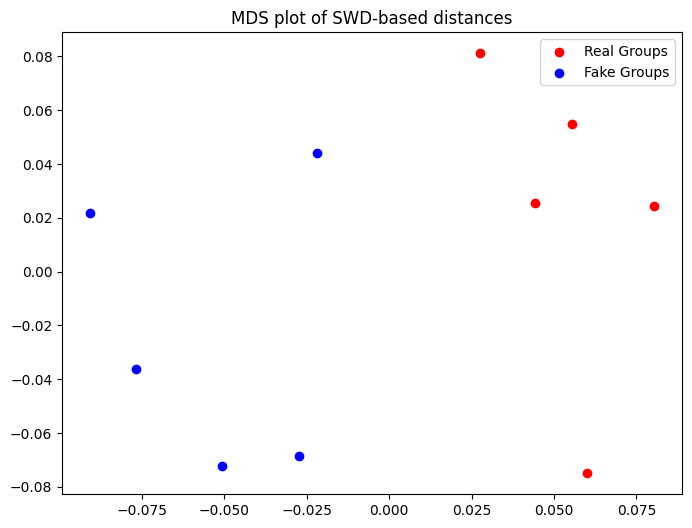

In [32]:
def group_descriptors(images, groups=10, group_size=20):
    # images: (N,1,64,64) pre-normalized in [-1,1]
    # pick "groups * group_size" images
    selected = images[:groups*group_size]
    selected_3c = np.repeat(selected, 3, axis=1)
    # Compute descriptors for each group
    group_descs = []
    idxs = np.arange(groups*group_size)
    for g in range(groups):
        batch = selected_3c[g*group_size:(g+1)*group_size]
        batch_uint8 = np.clip((batch*127.5+127.5),0,255).astype(np.uint8)
        desc = get_descriptors(batch_uint8)
        desc = desc.reshape(-1,3,5,5)
        desc = pixel_norm_desc(desc)
        group_descs.append(desc)
    return group_descs

real_groups = group_descriptors(real_subset, groups=5, group_size=20)
fake_groups = group_descriptors(fakes, groups=5, group_size=20)

all_groups = real_groups + fake_groups
G = len(all_groups)
dist_matrix = np.zeros((G,G))
for i in range(G):
    for j in range(i+1,G):
        dist = sliced_wasserstein(all_groups[i], all_groups[j])
        dist_matrix[i,j] = dist
        dist_matrix[j,i] = dist

# MDS embedding
mds = manifold.MDS(n_components=2, max_iter=300, eps=1e-9, dissimilarity="precomputed")
coos = mds.fit_transform(dist_matrix)

plt.figure(figsize=(8,6))
plt.scatter(coos[:5,0], coos[:5,1], c='r', label='Real Groups')
plt.scatter(coos[5:,0], coos[5:,1], c='b', label='Fake Groups')
plt.title("MDS plot of SWD-based distances")
plt.legend()
plt.show()


## **Conclusions and Future Improvements**

Overall, the progressive growing GAN pipeline demonstrates a strong capacity for capturing channelized patterns, short‐range continuity, and facies contrasts. While the generated models closely align with real geological data in terms of visual appearance and variogram trends, there remains a small distribution gap in advanced metrics such as SWD and a slight underrepresentation of long‐range correlations.

1.   Channel Capture: The progressive growing framework successfully learns core channel patterns and contrast.
2.   Continuity Metrics: Variograms indicate the model reproduces short‐range spatial structure but slightly underestimates longer‐range correlation.
3.   Distribution Proximity: SWD/MDS plots show the generated facies cluster near but not fully overlapping the real data.
4.   Visual Realism: Qualitative inspection reveals realistic facies geometries, with occasional minor blurring.

In order to further refine the geological fidelity of the generated facies, several architectural and training‐related adjustments can be implemented. These include more specialized GAN losses, domain‐specific metrics, and expanding the training dataset. We had to short the amount of images used for getting a better training.

1. Extended Training & Regularization: Longer training at higher resolutions, combined with alternative regularizations (e.g., R1 or non‐saturating logistic), may enhance fine‐scale details.
2. Advanced Architectures: Incorporating StyleGAN2 or skip connections can preserve sharp facies boundaries and improve spatial continuity.